# Libraries

In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import pandas as pd

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [8]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_tx_dfe, rf_analog, tonegen

reload(calc)
reload(ofdm)
reload(rf_tx_dfe)
reload(rf_analog)
reload(tonegen)

<module 'rfdsppy.tonegen' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/tonegen.py'>

# Tx IQ Mismatch Model and Compensation

In [ ]:
ep=-0.1
theta=-3*np.pi/180

# ep = 0.5
# theta = 10*np.pi/180

print(f"Expected image suppression = {10*np.log10(4/(ep**2+theta**2))}")

tx_iqmc = rf_tx_dfe.TxIQMC(ep, theta)
iq_upconverter = rf_analog.IQUpconverter(ep=ep, theta=theta)

Expected image suppression = 24.968374974868077


        Waveform   EVM (%)  SNR (dB)
0  CP-OFDM 16QAM  5.630141     24.99


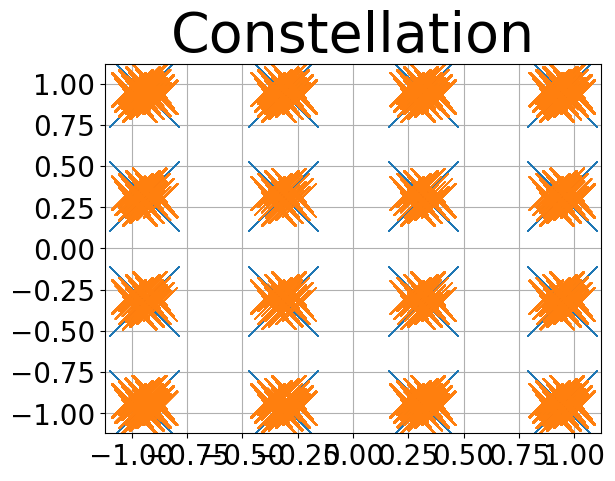

In [61]:
en_td_plot = False
en_psd_plot = False
en_const_plot = True

# Waveform params
en_tprecodes = [True, False] # DFT-s-OFDM, CP-OFDM
en_tprecodes = [False]
modorders = [4, 16, 64, 256]
modorders = [16]
wola = 0
bw = 20
scs = 15

# Sweep waveforms
out = {
    "Waveform": [],
    "EVM (%)": [],
    "SNR (dB)": [],
}
for en_tprecode in en_tprecodes:
    for modorder in modorders:

        # Initialize waveform generator
        wg = ofdm.OFDMWavGen(bw=bw, scs=scs, modorder=modorder, en_tprecode=en_tprecode, wola=wola)

        # Generate waveform
        x, x_standard = wg.generate(nsym=14, seed=0)
        cfg_evm = wg.get_demod_params()
        fs = cfg_evm.get("fs")
        wola_len = cfg_evm.get("wola_len")

        # Tx IQMC
        # x = tx_iqmc.transform(x)

        # Tx IQ mismatch model
        x = iq_upconverter.transform(x)
        
        # Plot time-domain samples
        if en_td_plot:
            fig = plt.figure()
            plt.plot(np.abs(np.concatenate((np.zeros(round(wg.wola_len/2)), x_standard, np.zeros(round(wg.wola_len/2))))))
            plt.plot(np.abs(x))
        
        # Plot PSDs
        if en_psd_plot:
            rbw = scs/1000/2**2
            p, f = calc.psd(x,fs,rbw)
            ps, f = calc.psd(x_standard,fs,rbw)
            fig = plt.figure()
            plt.plot(f, 10*np.log10(ps))
            plt.plot(f, 10*np.log10(p))
            plt.title("PSD", {'fontsize':40})
            plt.xlabel("Frequency (MHz)", {'fontsize':30})
            plt.ylabel("PSD (dB/Bin)", {'fontsize':30})
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.autoscale(enable=True, axis='both', tight=True)
            plt.grid()
        
        # EVM
        if en_const_plot:
            evm = wg.calculate_evm(x_standard, x[round(wola_len/2):], en_plot=True)
            # evm = ofdm.ofdm_evm_calculator(cfg_evm,x_standard,x[round(wola_len/2):])
            snr = round(-20*np.log10(evm/100),2)
        
        wavstr = 'DFT-s-OFDM ' if en_tprecode == 1 else 'CP-OFDM '
        wavstr = wavstr + 'QPSK' if modorder == 4 else wavstr + str(modorder) + 'QAM'
        out['Waveform'].append(wavstr)
        out['EVM (%)'].append(evm)
        out['SNR (dB)'].append(snr)

out = pd.DataFrame(out)
print(out)

# Tx IQ Mismatch Measurement

In [ ]:
ep=-0.1
theta=-3*np.pi/180

ep = 0.1
theta = -3*np.pi/180

# ep = 0.5
# theta = 10*np.pi/180

tx_iqmc = rf_tx_dfe.TxIQMC(ep, theta)
iq_upconverter = rf_analog.IQUpconverter(ep=ep, theta=theta)

In [21]:
# This is the configuration for the measurement (for example)

modorder = 4
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = True
osr = 1
ofdm_wavgen = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr)
cfg = ofdm_wavgen.get_demod_params()

awgn = rf_analog.AWGN(-10, bw, cfg.get("fs"))

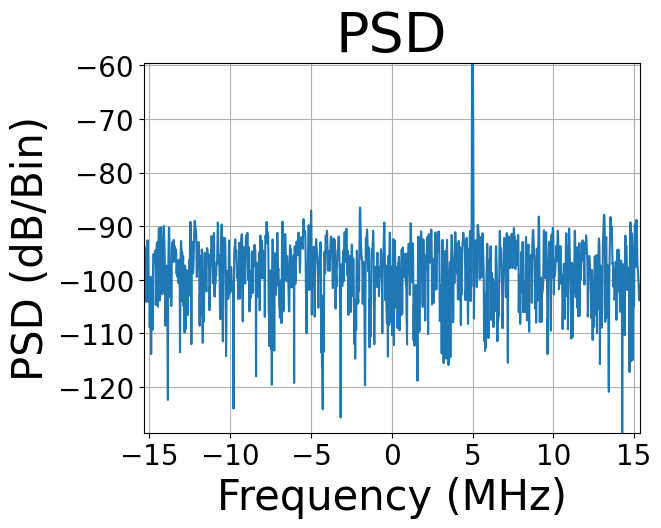

In [22]:
rng = np.random.default_rng()
fs = cfg.get("fs")
fc = 5
nsamp = 2048
x = tonegen.tonegen(fs, fc, cossin="exp", theta0=rng.uniform(0,2*np.pi), nsamp=nsamp, power=0)

# Tx IQMC
# x = tx_iqmc.transform(x)

# Tx IQ mismatch model
x = iq_upconverter.transform(x)

x = awgn.transform(x)

rbw = fs/nsamp
p, f = calc.psd(x,fs,rbw)
# ps, f = calc.psd(x_standard,fs,rbw)
fig = plt.figure()
# plt.plot(f, 10*np.log10(ps))
plt.plot(f, 10*np.log10(p))
plt.title("PSD", {'fontsize':40})
plt.xlabel("Frequency (MHz)", {'fontsize':30})
plt.ylabel("PSD (dB/Bin)", {'fontsize':30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.autoscale(enable=True, axis='both', tight=True)
plt.grid()
# plt.ylim(bottom=-100)

In [34]:
ep = -0.1
theta = -3*np.pi/180

ep = 0.1
theta = -3*np.pi/180

ep = -0.1
theta = 3*np.pi/180

ep = 0.1
theta = 3*np.pi/180

iq_upconverter = rf_analog.IQUpconverter(ep=ep, theta=theta)

rng = np.random.default_rng()
fs = 30.72
fc = 5
nsamp = 2048
x = tonegen.tonegen(fs, fc, cossin="exp", theta0=rng.uniform(0,2*np.pi), nsamp=nsamp, power=0)

y = iq_upconverter.transform(x)
y = awgn.transform(y)

wc = 2*np.pi*fc/fs

n = np.arange(len(y))

alpha = np.sum(y*np.exp(-1j*wc*n))
beta = np.sum(y*np.exp(1j*wc*n))
ab = alpha*beta

c2 = ab.imag/ab.real
c1 = alpha*alpha.conjugate()/(beta*beta.conjugate())

ep1 = np.sqrt(4/c1/(1+c2**2))*np.sign(ab.real)
theta1 = ep1*c2*np.sign(ab.imag)

print(ep1)
print(ep)
print(theta1)
print(theta)

(0.11943685698899752+0j)
0.1
(0.062412762902018+0j)
0.05235987755982988
